# Algoritmer i TMA4320 - Introduksjon til vitenskaplige beregninger

In [1]:
import autograd.numpy as np

from autograd import value_and_grad
from autograd import jacobian
import numpy.linalg as la
import matplotlib.pyplot as plt

## Modul 1


In [2]:
#intervallhalveringsmetoden:

def inthalv(f,a,b,tol):
    '''
    Input:
    f: funksjonen
    a: venstre side av startintervallet
    b: høyre side av startintervallet
    tol: akspetert feilskranke
    
    output:
    m: siste halveringspunkt
    iter: antall iterasjoner
    '''
    fa=f(a)
    fb=f(b)
    iter=0
    while abs(b-a) > tol:
        m=(a+b)/2.0
        iter=iter+1
        fm=f(m)
        if fa*fm<0:
            b=m
            fb=fm
        else:
            a=m
            fa=fm
        
    return m,iter

def f(x):
    return 1 - np.tan(x)

print(inthalv(f,0,1,0.1))

#Newtons metode for én likning

def gNewton(f, x0, tol):
    '''
    Input:
    f: funksjonen
    x0: startverdi
    tol: tolerert feil
    
    output:
    x: sisye itererte verdi
    iter: antall iterasjoner
    
    '''
    assert tol>0
    maxiter=100
    iter=0
    xp=x0
    est= float('inf')
    Df = value_and_grad(f)
    while est>tol and iter<maxiter:
        iter=iter+1
        T=Df(xp)
        x=xp-T[0]/T[1]
        est=np.abs(x-xp)
        xp=x
    return x, iter

def f(x):
    return 0.5*np.log(1.0+x**2)

print(gNewton(f,1.0,10**-4))



#Newtons metode for systemer


def sNewton(f,x0,tol):
    '''
    Input:
    f: funksjonen/system av likninger
    x0: startverdi (array)
    tol: tolerert feil
    
    output:
    x: sisye itererte verdi
    iter: antall iterasjoner
    '''
    iter=0
    maxiter=100
    Df=jacobian(f)      
    est=2.*tol
    x=x0
    while est>tol and iter<maxiter:
        iter=iter+1
        delta=la.solve(Df(x),-f(x))
        est=la.norm(delta)
        x=x+delta
    return x, iter

    



(0.8125, 4)
(7.048656522306153e-05, 13)


## Modul 2

In [3]:
x = np.array([0.0,3.0,1]) # x coordinates in space
y = np.array([0,1.0,0.5]) # f(x)


def getNDDCoeffs(x, y):
    """ Creates NDD pyramid and extracts coeffs """
    n = np.shape(y)[0]
    pyramid = np.zeros([n, n]) # Create a square matrix to hold pyramid
    pyramid[::,0] = y # first column is y
    for j in range(1,n):
        for i in range(n-j):
            # create pyramid by updating other columns
            pyramid[i][j] = (pyramid[i+1][j-1] - pyramid[i][j-1]) / (x[i+j] - x[i])
    return pyramid[0] # return first row

coeff_vector = getNDDCoeffs(x, y)
print(coeff_vector)
    
    



[ 0.          0.33333333 -0.08333333]


## Modul 3

In [4]:
# Trapesformelen
import numpy as np

def f(x):
    return 1/(x**2+1)

def trapesformula(f,a,b,n):
    h=(b-a)/n
    result= h/0.2 *(f(a)+f(b))
    for k in range(1,n):
        result += f(a+k*h)
    return h*result


#Simpsons metode

def simpson(f,a,b,m):
    h = (b-a)/(2*m)
    result = f(a) + f(b)
    for i in range(1,int(m+1)):
        result += 4*f(a + (2*i-1)*h )
        if i < m:
            result += 2*f(a + 2*i*h)
    return h/3*result


def f(x):
    return x**2 + np.log(x)

m = 0.25*(1)*2
print(simpson(f,1,2,m))


1.8977157268533151


## Modul 4

In [4]:
#PA=LU faktorisering

def mylu(A):
    """
    Compute the LU-factoring of a matrix with partial pivoting.

    Input
       A: the square matrix to be LU-factored
    Output
       LU: Matrix containing L and U. 
                  L = tril(LU(P,:),-1)+eye(n)
                  U = triu(LU(P,:))
        P: A vector with a permutation of the integers (1:n)' 
    """
    n, m = A.shape
    if m != n:
        raise ValueError('Matrix must be square')
    
    eps = np.finfo(A.dtype).eps
    LU = A.copy()  # Only needed if A is used later.
    P = list(range(n))
    
    for k in range(n-1): 
        pivot = np.argmax(abs(LU[P[k:], k]))
        val = (LU[P[k:], k])[pivot] # TODO: UGLY!
        if abs(val) < np.sqrt(eps): # Use square root of machine precision as threshold for singular
            raise ValueError('Matrix is singular to working precision')
        pivot = pivot + k # local to global pivot.
        
        print(LU)
        print("k:" + str(k))
        print("pivot: " + str(pivot))

        #swap elements in pivot vector
        P[pivot], P[k] = P[k], P[pivot]
        
        mults = LU[P[k+1:],k] / LU[P[k],k]
        LU[P[k+1:], k+1:] = LU[P[k+1:],k+1:] - np.outer(mults,LU[P[k],k+1:])
        LU[P[k+1:], k] = mults

    return LU, P

# Her gjengis de oppgitte funksjoner for substitusjon
def forward_subs(LU,P,b):
    n, m = LU.shape
    Pb = b[P]
    c = np.zeros(n)
    c[0] = Pb[0]
    for k in range(1,n):
        c[k] = Pb[k] - LU[P[k],0:k] @ c[0:k]
        
    return c

def backward_subs(LU,P,c):
    n,m = LU.shape
    x = np.zeros(n)
    x[n-1] = c[n-1]/LU[P[n-1],n-1]
    for k in range(n-1,0,-1):
        x[k-1] = (c[k-1]-LU[P[k-1],k:] @ x[k:])/LU[P[k-1],k-1]
        
    return x

def getAb():
    A=np.array([[0.3050, 0.5399, 0.9831, 0.4039, 0.1962],
                [0.2563, -0.1986, 0.7903, 0.6807, 0.5544],
                [0.7746, 0.6253, -0.1458, 0.1704,  0.5167],
                [0.4406, 0.9256, 0.4361, -0.2254, 0.7784],
                [0.4568, 0.2108, 0.6006, 0.3677, -0.8922]])
    b=np.array([0.9876,-1.231,0.0987,-0.5544,0.7712])
    return A,b

A,b = getAb()
LU, P = mylu(A)
c = forward_subs(LU,P,b)
x = backward_subs(LU,P,c)

#Cholesky

def cholesky(A):
    ''' A er en positiv definitt matrise som returnerer en nedretriangulær matrise L
    
    '''
    n=A.shape[1]
    L=np.zeros(A.shape)
    for i in range(n):
        for j in range(i):
            L[i,j]=(A[i,j] - L[i,:j] @ L[j,:j])/L[j,j]
        L[i,i] = np.sqrt(A[i,i]-L[i,:i] @ L[i,:i])
    
    return L

A = np.array(([1,2],[2,20]))
#print(cholesky(A))

def substit(L,b):
    '''For en nedretriangulær matrise L (nxn) og en vektor b (nx1) finn c (nx1) slik at Lc=b og deretter 
    '''
    c=np.zeros(b.shape)
    n=c.size
    c[0]=b[0]/L[1,1];
    for k in range(1,n):
        c[k] = (b[k] - L[k,:k] @ c[:k])/L[k,k]
    x=np.zeros(b.shape)
    x[n-1] = c[n-1]/L[n-1,n-1]
    for k in range(n-1,0,-1):
        x[k-1]=(c[k-1] - L[k:,k-1] @ x[k:])/L[k-1,k-1]
    
    return x

'''
Example
    L = cholesky(A)
    x = substit(L,b)
'''


#Iterative metoder: 

#Jacobi-metoden

def jacobi(x0,A,b,N):
    n,m = A.shape
    Dinv = np.zeros((n,m))
    L = np.zeros((n,m))
    U = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if(i == j):
                Dinv[i,j] =  1/A[i,j]
            elif(i > j):
                L[i,j] = A[i,j]
            elif(i < j):
                U[i,j] = A[i,j]
    x = x0          
    for i in range(N):
          x = Dinv @ (b-(L+U) @ x)
    return x


def gauss_seidel(x0,A,b,N):
    x = x0
    for k in range(N):
        for i in range(len(x)):
            x[i] = b[i]

            for j in range(len(x)):
                if j < i:
                    x[i] -= A[i,j]*x[j]
                elif j > i:
                    x[i] -= A[i,j]*x[j]
            x[i] = x[i]/A[i,i]
        print(x)
    return x
        

A = np.array(([1,0.8,1],[1,1,0.6],[1,1,1]) )  
b = np.array([1.0,0.0,1.0])
x = np.array([-1.0,0.0,2.0])
#print("hei")
#print(gauss_seidel(x0,A,b,2))



'''
Example:
            
A = np.array(([3,1],[1,2]))
b = np.array(([5,5]))
x0 = np.array(([0,0]))
print(jacobi(x0,A,b,10))
print(gauss_seidel(x0,A,b,10))

'''

def seidel(a, x ,b): 
    #Finding length of a(3)        
    n = len(a)                    
    # for loop for 3 times as to calculate x, y , z 
    for j in range(0, n):         
        # temp variable d to store b[j] 
        d = b[j]                   
          
        # to calculate respective xi, yi, zi 
        for i in range(0, n):      
            if(j != i): 
                d-=a[j][i] * x[i] 
        # updating the value of our solution         
        x[j] = d / a[j][j] 
    # returning our updated solution            
    return x

for i in range(0, 100):             
    x = seidel(A, x, b) 
    #print each time the updated solution 
    print(x) 

[[ 0.305   0.5399  0.9831  0.4039  0.1962]
 [ 0.2563 -0.1986  0.7903  0.6807  0.5544]
 [ 0.7746  0.6253 -0.1458  0.1704  0.5167]
 [ 0.4406  0.9256  0.4361 -0.2254  0.7784]
 [ 0.4568  0.2108  0.6006  0.3677 -0.8922]]
k:0
pivot: 2
[[ 0.39375161  0.29368712  1.04050899  0.33680473 -0.00725146]
 [ 0.33088045 -0.40549955  0.83854237  0.62431797  0.38343407]
 [ 0.7746      0.6253     -0.1458      0.1704      0.5167    ]
 [ 0.56880971  0.56992329  0.51903246 -0.32232517  0.48449602]
 [ 0.58972373 -0.15795425  0.68658172  0.26721108 -1.19691025]]
k:1
pivot: 3
[[ 0.39375161  0.5153099   0.77304642  0.50290208 -0.25691706]
 [ 0.33088045 -0.71149847  1.20783317  0.3949841   0.72815225]
 [ 0.7746      0.6253     -0.1458      0.1704      0.5167    ]
 [ 0.56880971  0.56992329  0.51903246 -0.32232517  0.48449602]
 [ 0.58972373 -0.27715001  0.83043157  0.17787865 -1.06263217]]
k:2
pivot: 3
[[ 0.39375161  0.5153099   0.64002748  0.2501014  -0.72295451]
 [ 0.33088045 -0.71149847  1.20783317  0.3949841  

## Modul 5

In [ ]:
#Eulers metode

def step_Euler(y, h, f, t_i, n):  
    next_y = y + h * f(y, t_i, n)   
    return next_y

def RK4_step(y, h, f, t_i, n):  
    s1 = f(y, t_i, n)
    s2 = f(y + (h / 2) * s1, t_i + h/2, n)  
    s3 = f(y + (h / 2) * s2, t_i + h/2, n) 
    s4 = f(y + h * s3, t_i + h, n) 
    return y + (h / 6) * (s1 + (2 * s2) + (2 * s3) + s4)

def numerical_solution(h, f, y_0, start_t, n, method): 
    t_list = np.zeros(1)
    y_list = np.zeros((1,2))
    t_list[0] = start_t
    y_list[0] = y_0
    
    i=0
    while True:
        val = method(y_list[i], h, f, t_list[i], n)  

        y_list = np.vstack((y_list, y_0))         
        t_list = np.append(t_list, start_t)     
        y_list[i+1] = val
        t_list[i+1] = t_list[i] + h 
        i += 1
        if val[0] <= 0:  
            break

    return y_list, t_list 

## Relevante oppgaver

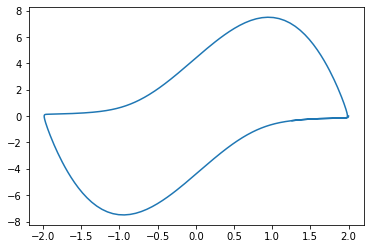

Y[:,1000]= [-1.01969992  0.60211016]


In [64]:
'''
Baklengs Euler kombinert med Newtons formel for systemer
'''
import autograd.numpy as np
from autograd import jacobian


def sNewton(f,x0,tol):
    iter=0
    maxiter=100
    Df=jacobian(f)      
    est=2.*tol
    x=x0
    while est>tol and iter<maxiter:
        iter=iter+1
        delta=la.solve(Df(x),-f(x))
        est=la.norm(delta)
        x=x+delta
    return x, iter


def beuler_step(yn,f,h,tol):
    ''' Ta ett skritt med baklengs Euler der 
    yn: initialverdien til skrittet
    P: En klasse som inneholder to funksjoner
        P.f: funksjon som tar ett argument y (numpy array) og returnerer dy=y'=f(y)  (numpy array)
        P.Jf: funksjon som tar ett argument y (numpy array) og returnerer jacobi-matrisen J_f(y) (2D numpy array)
    h: Skrittlengde
    tol: toleranse i Newtoniterasjonen
    Returnerer løsningen etter ett skritt
    '''
    m=yn.size
    z=yn
    newton_error=tol+1
    k=0
    I = np.eye(m)
    Df = jacobian(f)
    while newton_error > tol:
        A=I-h*Df(z)
        b=yn+h*f(z)-z
        delta = np.linalg.solve(A,b)
        z=z+delta
        newton_error=np.linalg.norm(delta)
        k+=1
        if k>1000:
            print('Too many iterations')
            break    
    return z

def beuler(y0,f,h,tol,nsteps):
    ''' Ta nsteps skritt med baklengs Euler
    y0: StStartverdien, numpy-array
    P: Brukerdefinert klasse som beskrevet i beuler_step
    h: Skrittlengde brukt i integrasjonen (se beuler_step)
    tol: Toleranse brukt i Newtoniterasjonen (se beuler_step)
    nsteps: Antall skritt i integrasjonen, løsningsintevallet er [0,h*nsteps]
    Returner Y, et 2x(nsteps+1) numpy array der kolonne k er [yk, yk']^T, numerisk løsning ved tid t=k*h
    '''
    
    m=y0.size
    Y = np.zeros((m,nsteps+1))
    Y[:,0]=y0
    for k in range(nsteps):
        Y[:,k+1]=beuler_step(Y[:,k],f,h,tol)
        
    return Y

def f(y,mu = 5):
    return np.array([y[1],mu*(1-y[0]**2)*y[1]-y[0]])

y0=np.array([2,0])
tol=1e-6
h=0.01
nsteps=1500
Y=beuler(y0,f,h,tol,nsteps)
plt.plot(Y[0,:],Y[1,:])
plt.show()
print('Y[:,1000]=', Y[:,1000])
